# Praca domowa nr 6
Author: Piotr Halama

In [1]:
import random
from copy import copy

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from pygam import LinearGAM

from scipy.stats import f

##### Data

In [2]:
data = pd.read_stata('../../../HCMST 2017 fresh sample for public sharing draft v1.1.dta')

variables = ['w6_q21d_month', 'w6_q21d_year', 'w6_q25', 'w6_q26']

Chosen variables:
- w6_q21d_month - Month subject married partner
- w6_q21d_year - Year subject married partner
- w6_q25 - Did subject and partner attend same high school?
- w6_q26 - Did subject and partner attend same college?

Target variable: S1 - Are you married?

##### Preprocessing

In [3]:
X = data[variables]
y = data['S1']

X = X[pd.notnull(y)]
y = y[pd.notnull(y)]

months = [
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
    'September', 'October', 'November', 'December'
]

X['w6_q21d_month'] = X['w6_q21d_month'].astype('category').cat.set_categories(
    months, ordered=True)

X['w6_q25'] = X['w6_q25'].astype('category').cat.as_unordered()
X['w6_q26'] = X['w6_q26'].astype('category').cat.set_categories(
    ['Refused', 'Same College', 'Different College'],
    rename=True,
    ordered=False)
y = y.astype('category')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)

##### Model

The classifier used here is based on gradient boosting from `LightGBM` package.

In [4]:
clf = LGBMClassifier(reg_alpha=0.5)
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.5, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [5]:
y_pred = clf.predict(X_test)

f1_score(y_test, y_pred, pos_label='Yes, I am Married')

0.963855421686747

## Homework Solution

In [22]:
y_ = (y_train == 'Yes, I am Married').apply(int)
y_hat = clf.predict_proba(X_train)[:, 1]
res = y_ - y_hat

### Residuals distribution

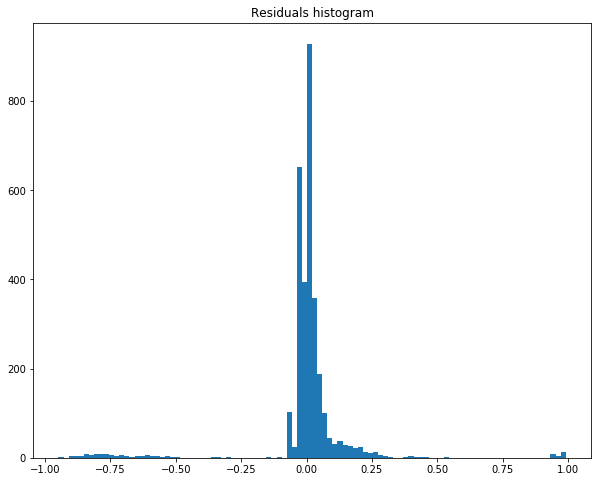

In [24]:
plt.figure(figsize=(10,8))

plt.hist(res, bins=100)
plt.title('Residuals histogram')
plt.show()

### Residuals vs Fitted values plot

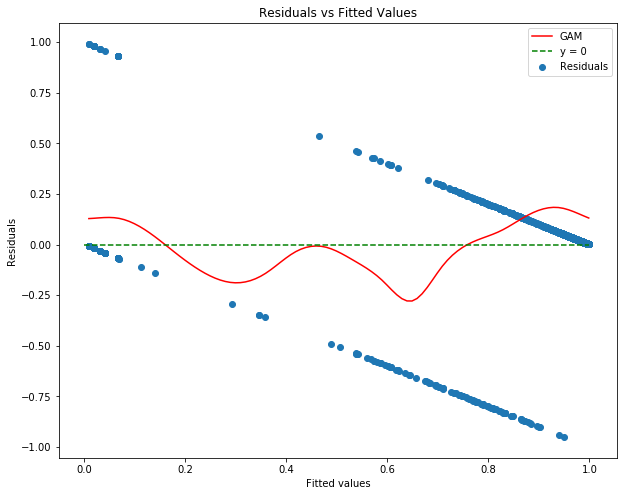

In [7]:
gam = LinearGAM().fit(y_hat, y_ - y_hat)

term = gam.terms[0]
XX = gam.generate_X_grid(term=0)
pdep = gam.partial_dependence(term=0, X=XX)

plt.figure(figsize=(10, 8))

plt.scatter(y_hat, y_ - y_hat, label='Residuals')
plt.plot(XX[:, term.feature], pdep, c='r', label='GAM')
plt.plot(np.linspace(0, 1, 10), np.repeat(0, 10), c='g', ls='--', label='y = 0')

plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title("Residuals vs Fitted Values")
plt.legend()

plt.show()

### Residuals vs Dependent Variable plot

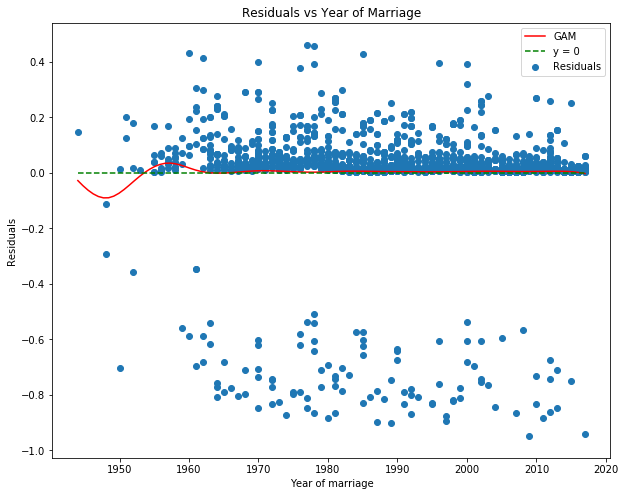

In [8]:
dep = X_train['w6_q21d_year']

res = res[pd.notna(dep)]
dep = dep[pd.notna(dep)]

gam = LinearGAM().fit(dep, res)

term = gam.terms[0]
XX = gam.generate_X_grid(term=0)
pdep = gam.partial_dependence(term=0, X=XX)

plt.figure(figsize=(10, 8))

plt.scatter(dep, res, label='Residuals')
plt.plot(XX[:, term.feature], pdep, c='r', label='GAM')
plt.plot(np.linspace(np.min(dep), np.max(dep), 10), np.repeat(0, 10), c='g', ls='--', label='y = 0')

plt.xlabel('Year of marriage')
plt.ylabel('Residuals')
plt.title("Residuals vs Year of Marriage")
plt.legend()

plt.show()

### Cook's distance

In [9]:
n, p = X_train.shape

s2 = np.sum(res**2) / (n - p)
f05 = f.median(p, n - p)

In [13]:
cooks = list()
# influence = list()

for i in range(n):
    X_i = X_train.copy().drop(X_train.index[i])
    y_i = y_train.copy().drop(y_train.index[i])

    clfi = LGBMClassifier(reg_alpha=0.5)
    clfi.fit(X_i, y_i)
    yi_hat = clfi.predict_proba(X_train)[:, 1]
    
    cooks.append(np.sum(np.power(y_hat - yi_hat, 2))/(p * s2))
    # influence.append(np.sqrt(np.mean(np.power(y_hat - yi_hat, 2))))

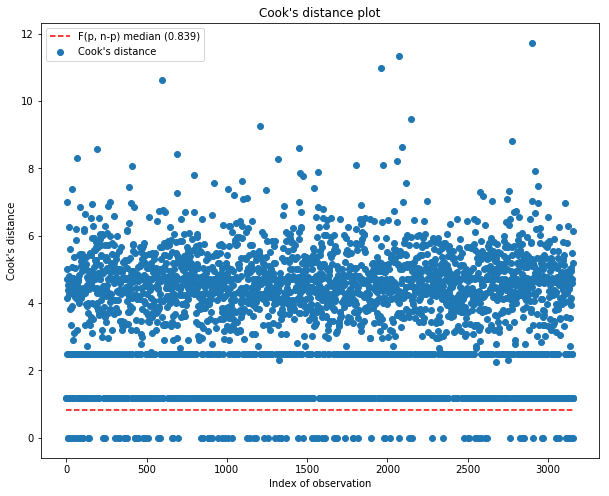

In [14]:
plt.figure(figsize=(10, 8))

plt.scatter(range(n), cooks, label='Cook\'s distance')
plt.plot(np.linspace(0, n, 10), np.repeat(f05, 10), c='r', ls='--', label=f'F(p, n-p) median ({f05:.3})')

plt.xlabel('Index of observation')
plt.ylabel('Cook\'s distance')
plt.title("Cook's distance plot")
plt.legend()

plt.show()

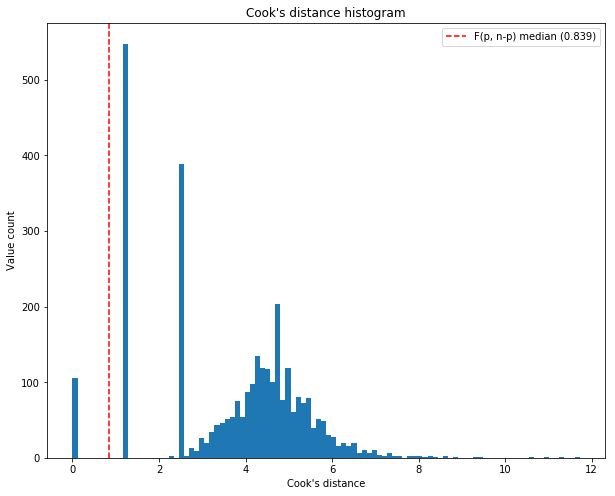

In [15]:
plt.figure(figsize=(10, 8))

plt.hist(cooks, bins=100)
plt.axvline(x=f05, color='r', ls='--',  label=f'F(p, n-p) median ({f05:.3})')

plt.xlabel('Cook\'s distance')
plt.ylabel('Value count')
plt.title("Cook's distance histogram")
plt.legend()

plt.show()

## Conclusion

### Residual vs Fitted values plot
The plot shows sharp divide in predictions of the model - there are almost no points for fitted values between 0.1 and 0.5.

### Residual vs Year of Marriage plot
GAM fitted to the plot of residuals almost perfectly lies on the y=0 line. Only for pairs married in the '60s model predicts lower probability of them being married than it should, and for the pairs married in the '50s - higher probability. This can be probably explained by smaller amount of data for the pairs from that time span.

### Cook's distance
Almost all observations (apart from about 100 observations) have Cook's distance higher than the median of F(p, n-p) distribution. The model is not very robust, as any change greatly alters its predictions.